In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from catboost import CatBoostClassifier

In [2]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df['text'].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [5]:
test_df.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df = train_df.rename(columns={'target': 'label'})

In [7]:
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Display basic information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   label     7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
label          0
dtype: int64

In [10]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [11]:
keywords = train_df['keyword'].unique()
keywords

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [12]:
def clean_text(text):
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    # remove digits
    text = re.sub(r'\d+', '', text)
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove extra spacese
    text = re.sub(r'\s+', ' ', text).strip()
    # convert to lower case
    text = text.lower()

    return text

In [13]:
# Apply the cleaning function to both DataFrames
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [14]:
test_ids = test_df['id']

# Drop unnecessary columns
train_df.drop(columns=['id', 'location', 'keyword'], inplace=True)
test_df.drop(columns=['id', 'location', 'keyword'], inplace=True)

In [15]:
# Balance class distribution
# Features and labels
X = train_df['text']
y = train_df['label']

# Oversampling
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert resampled data back to DataFrame
train_df = pd.DataFrame({'text': X.flatten(), 'label': y})

# 词频相关

In [16]:
import os

# 创建 figure 文件夹（如果不存在）
os.makedirs("figure", exist_ok=True)


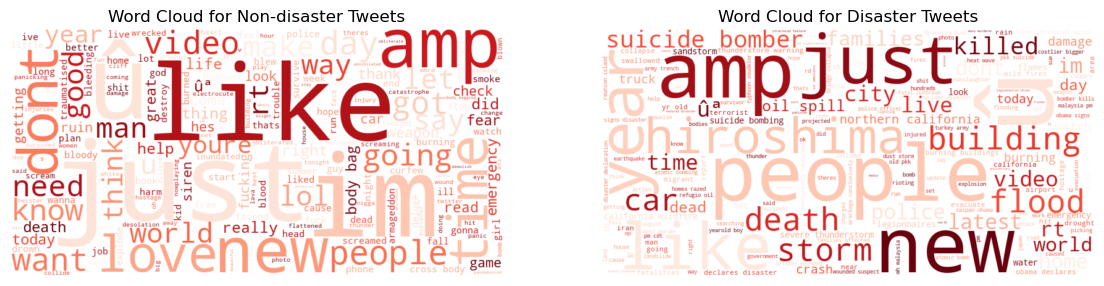

In [17]:
# label 0和1分别生成词云
train_df_0 = train_df[train_df['label'] == 0]
text_data0 = " ".join(train_df_0['text'])
train_df_1 = train_df[train_df['label'] == 1]
text_data1 = " ".join(train_df_1['text'])

# Generate word cloud with a red color scheme
wordcloud0 = WordCloud(
    stopwords=ENGLISH_STOP_WORDS,
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    colormap='Reds'  # Use 'Reds' colormap for shades of red
).generate(text_data0)

wordcloud1 = WordCloud(
    stopwords=ENGLISH_STOP_WORDS,
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    colormap='Reds'  # Use 'Reds' colormap for shades of red
).generate(text_data1)

# Display the word cloud
plt.figure(figsize=(14, 7))

# label 0 的词云
plt.subplot(1, 2, 1)
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Non-disaster Tweets")

# label 1 的词云
plt.subplot(1, 2, 2)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Disaster Tweets")

# 保存词云到 figure 文件夹
wordcloud0.to_file("figure/wordcloud_non_disaster.png")
wordcloud1.to_file("figure/wordcloud_disaster.png")

plt.show()

标签 0 的词云（左侧）
常见词汇：amp, im, like, just, new, day, time, want。
关键词分析：
标签 0 的词汇似乎更多地集中在日常生活的表达上，而非与灾难直接相关。词汇如 im、like、want、say、time、day 等，表明推文内容更多是情感表达或日常话题。
某些词，如 curfew、emergency、death 等，虽然有紧急或负面情绪，但并非直接描述灾难，而是较为轻微或间接的情感。
amp 这种词出现，可能是推文中的 URL 或缩写被误认为是关键词，也说明了预处理过程中可能遗漏了一些不相关的符号或短语。
标签 1 的词云（右侧）
常见词汇：new, people, year, flood, suicide, storm, death, hiroshima。
关键词分析：
标签 1 的关键词与灾难主题更相关。比如 flood（洪水）、suicide（自杀）、storm（风暴）、death（死亡）、evacuate（疏散）、crash（撞车）等词汇明显与灾难、危险事件或负面新闻有关。
还包含一些特定地点或事件，如 hiroshima（广岛），可能与特定的历史事件或灾难相关。
词汇 flood、storm、evacuate 等紧急情况相关的词语突出，说明标签 1 更倾向于描述自然灾害、公共安全事件或人道危机。

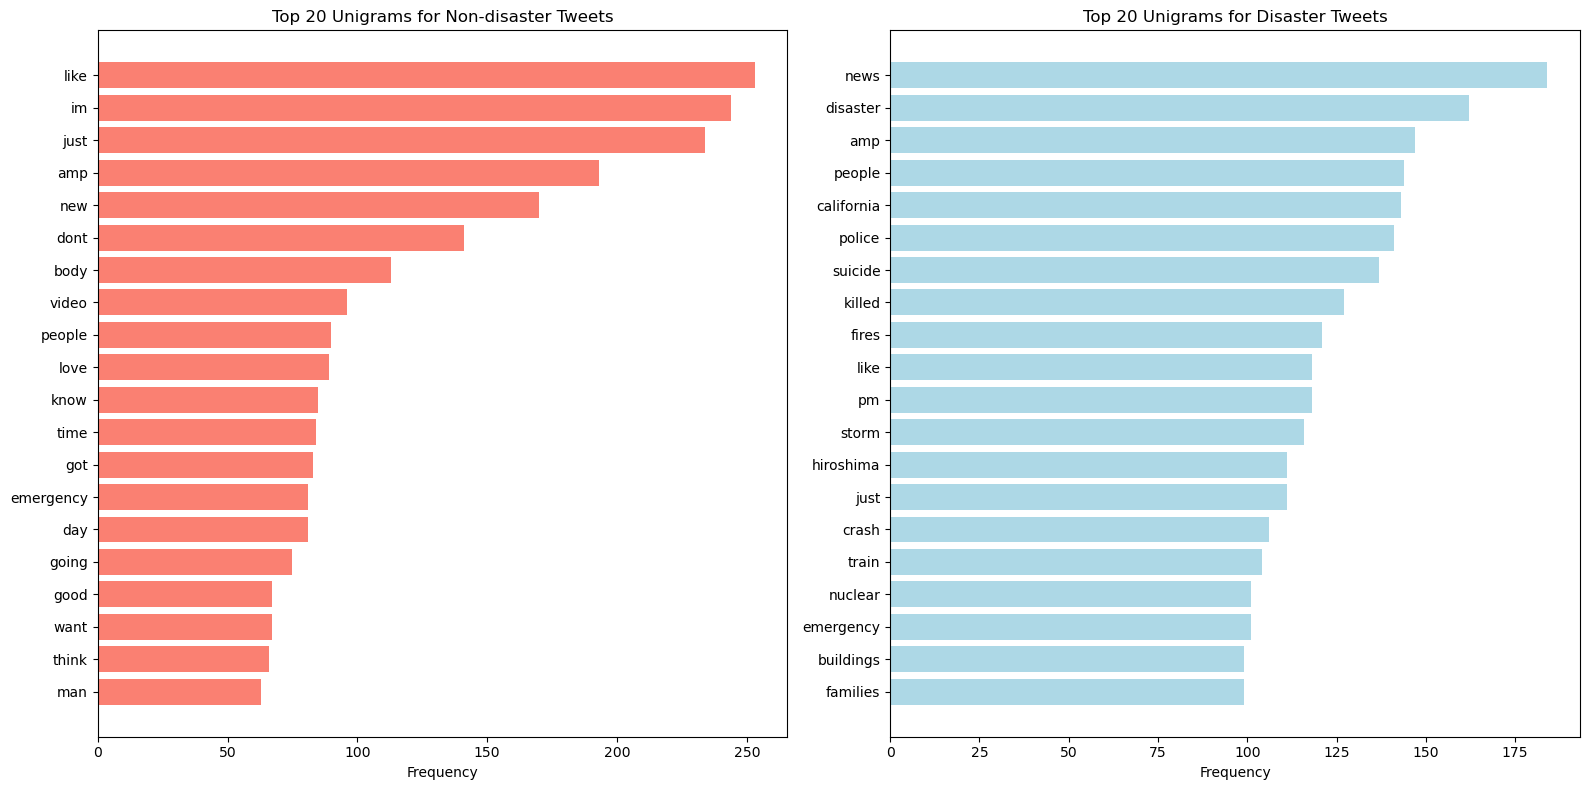

In [18]:
# 定义一个函数用于获取 top N 的 unigram 词频
def get_top_unigrams(text_data, top_n=20):
    # 使用 CountVectorizer 提取 unigram 特征
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(text_data)
    
    # 获取词频
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    
    # 创建 DataFrame
    unigram_df = pd.DataFrame({'word': words, 'count': word_counts})
    unigram_df = unigram_df.sort_values(by='count', ascending=False)
    return unigram_df

# 获取标签为 0 的文本数据
train_df_0 = train_df[train_df['label'] == 0]
text_data0 = train_df_0['text'].dropna().tolist()
unigram_df_0 = get_top_unigrams(text_data0, top_n=20)

# 获取标签为 1 的文本数据
train_df_1 = train_df[train_df['label'] == 1]
text_data1 = train_df_1['text'].dropna().tolist()
unigram_df_1 = get_top_unigrams(text_data1, top_n=20)

# 并排显示两个柱状图
plt.figure(figsize=(16, 8))

# 标签为 0 的柱状图
plt.subplot(1, 2, 1)
plt.barh(unigram_df_0['word'], unigram_df_0['count'], color='salmon')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Unigrams for Non-disaster Tweets")

# 标签为 1 的柱状图
plt.subplot(1, 2, 2)
plt.barh(unigram_df_1['word'], unigram_df_1['count'], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Unigrams for Disaster Tweets")

plt.tight_layout()
plt.show()


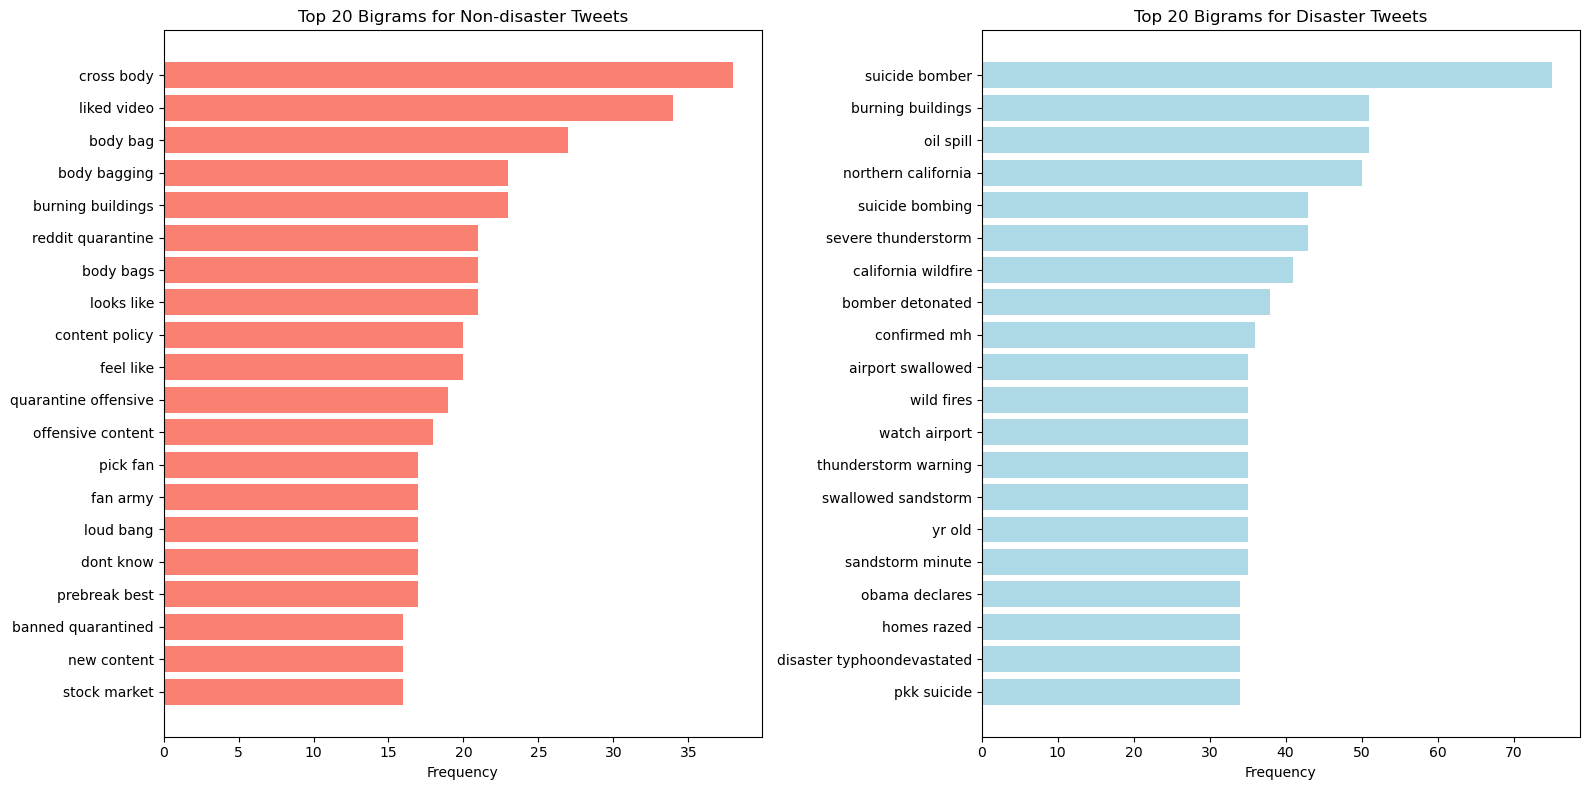

In [19]:
# 定义一个函数用于获取 top N 的 bigram 词频
def get_top_bigrams(text_data, top_n=20):
    # 使用 CountVectorizer 提取 bigram 特征
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=top_n)
    X = vectorizer.fit_transform(text_data)
    
    # 获取词频
    bigram_counts = X.toarray().sum(axis=0)
    bigrams = vectorizer.get_feature_names_out()
    
    # 创建 DataFrame
    bigram_df = pd.DataFrame({'bigram': bigrams, 'count': bigram_counts})
    bigram_df = bigram_df.sort_values(by='count', ascending=False)
    return bigram_df

# 获取标签为 0 的文本数据
train_df_0 = train_df[train_df['label'] == 0]
text_data0 = train_df_0['text'].dropna().tolist()
bigram_df_0 = get_top_bigrams(text_data0, top_n=20)

# 获取标签为 1 的文本数据
train_df_1 = train_df[train_df['label'] == 1]
text_data1 = train_df_1['text'].dropna().tolist()
bigram_df_1 = get_top_bigrams(text_data1, top_n=20)

# 并排显示两个 bigram 柱状图
plt.figure(figsize=(16, 8))

# 标签为 0 的 bigram 柱状图
plt.subplot(1, 2, 1)
plt.barh(bigram_df_0['bigram'], bigram_df_0['count'], color='salmon')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Bigrams for Non-disaster Tweets")

# 标签为 1 的 bigram 柱状图
plt.subplot(1, 2, 2)
plt.barh(bigram_df_1['bigram'], bigram_df_1['count'], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Bigrams for Disaster Tweets")

plt.tight_layout()
plt.savefig("figure/top_bigrams_comparison.png", dpi=300)
plt.show()


非灾难性推文（左图）
常见 bigram：cross body, liked video, body bag, reddit quarantine, quarantine offensive。
关键词分析：
非灾难性推文中的 high-frequency bigram 多与日常用语、社交媒体术语或轻微的负面情绪表达相关。
比如，liked video、looks like 反映了社交媒体互动，而 reddit quarantine、content policy、banned quarantined 等可能与疫情相关的社交媒体内容过滤或讨论相关。
body bag 虽然可能看似负面，但在非灾难性语境中可能有不同的含义，例如形容包的款式。
总体而言，这些 bigram 更多集中在社交互动或轻微争议话题上，而非具体的灾难事件。
灾难性推文（右图）
常见 bigram：suicide bomber, burning buildings, oil spill, northern california, severe thunderstorm。
关键词分析：
灾难性推文中的 high-frequency bigram 多与实际的灾难、事故或紧急事件密切相关。
例如，suicide bomber、oil spill、california wildfire、thunderstorm warning 等词汇明显与灾难、恐怖袭击或紧急情况有关。
bomber detonated、confirmed mh（可能指马航 MH370 事件）、disaster typhoon、wild fires 等 bigram 显示出这些推文涉及更为严肃的灾难性主题。
总体上，这些 bigram 清楚地表明了灾难性推文与实际事件、地理位置（如 northern california）和灾难类型的密切联系。


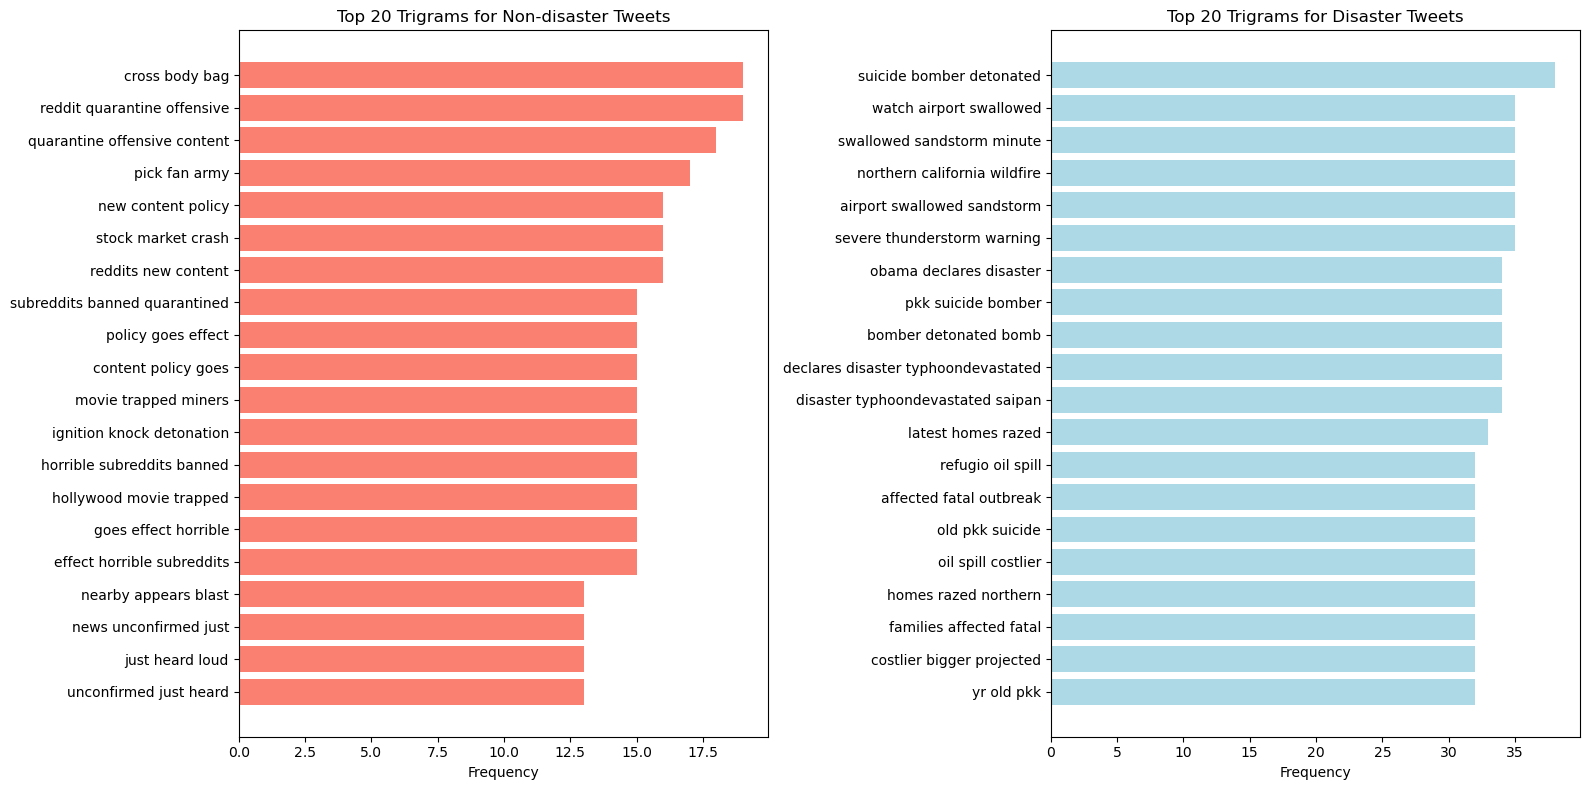

In [20]:
# 定义一个函数用于获取 top N 的 trigram 词频
def get_top_trigrams(text_data, top_n=20):
    # 使用 CountVectorizer 提取 trigram 特征
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3), max_features=top_n)
    X = vectorizer.fit_transform(text_data)
    
    # 获取词频
    trigram_counts = X.toarray().sum(axis=0)
    trigrams = vectorizer.get_feature_names_out()
    
    # 创建 DataFrame
    trigram_df = pd.DataFrame({'trigram': trigrams, 'count': trigram_counts})
    trigram_df = trigram_df.sort_values(by='count', ascending=False)
    return trigram_df

# 获取标签为 0 的文本数据
train_df_0 = train_df[train_df['label'] == 0]
text_data0 = train_df_0['text'].dropna().tolist()
trigram_df_0 = get_top_trigrams(text_data0, top_n=20)

# 获取标签为 1 的文本数据
train_df_1 = train_df[train_df['label'] == 1]
text_data1 = train_df_1['text'].dropna().tolist()
trigram_df_1 = get_top_trigrams(text_data1, top_n=20)

# 并排显示两个 trigram 柱状图
plt.figure(figsize=(16, 8))

# 标签为 0 的 trigram 柱状图
plt.subplot(1, 2, 1)
plt.barh(trigram_df_0['trigram'], trigram_df_0['count'], color='salmon')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Trigrams for Non-disaster Tweets")

# 标签为 1 的 trigram 柱状图
plt.subplot(1, 2, 2)
plt.barh(trigram_df_1['trigram'], trigram_df_1['count'], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Frequency")
plt.title("Top 20 Trigrams for Disaster Tweets")

plt.tight_layout()
plt.show()


# 文本长度

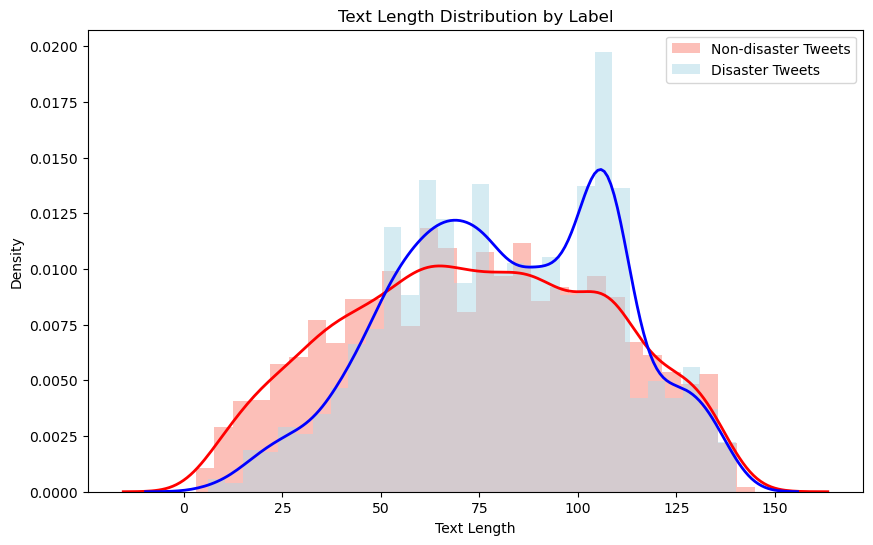

In [21]:
# 计算文本长度
train_df['text_length'] = train_df['text'].dropna().apply(len)

# 根据 label 分组
text_length_0 = train_df[train_df['label'] == 0]['text_length']
text_length_1 = train_df[train_df['label'] == 1]['text_length']

# 绘制叠加的直方图和 KDE 曲线
plt.figure(figsize=(10, 6))

# 绘制 label 0 的直方图和 KDE 曲线
plt.hist(text_length_0, bins=30, alpha=0.5, color='salmon', label='Non-disaster Tweets', density=True)
sns.kdeplot(text_length_0, color='red', linewidth=2)

# 绘制 label 1 的直方图和 KDE 曲线
plt.hist(text_length_1, bins=30, alpha=0.5, color='lightblue', label='Disaster Tweets', density=True)
sns.kdeplot(text_length_1, color='blue', linewidth=2)

# 添加标题和标签
plt.title("Text Length Distribution by Label")
plt.xlabel("Text Length")
plt.ylabel("Density")
plt.legend()
plt.show()

# TF-IDF

In [22]:
train_df['text'][3]

'people receive wildfires evacuation orders in california'

In [45]:
# 将文本数据转换为 TF-IDF 特征
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_df['text'])
y = train_df['label']

In [46]:
X

<8684x14740 sparse matrix of type '<class 'numpy.float64'>'
	with 106847 stored elements in Compressed Sparse Row format>

In [47]:
# 将数据分为训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# 使用SVM
# 设置参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

# 使用 GridSearchCV 进行参数调优
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_val)

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [49]:
# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

F1 Score: 0.8365155131264916
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       858
           1       0.88      0.80      0.84       879

    accuracy                           0.84      1737
   macro avg       0.85      0.84      0.84      1737
weighted avg       0.85      0.84      0.84      1737



In [50]:
# 使用logistic regression

#设置参数网格
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # C 为逻辑回归的正则化参数

# 使用 GridSearchCV 进行交叉验证和参数调优
logreg_model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_logistic = grid_search.best_estimator_
y_pred = best_logistic.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'C': 10}
F1 Score: 0.8336231884057971
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       858
           1       0.85      0.82      0.83       879

    accuracy                           0.83      1737
   macro avg       0.84      0.83      0.83      1737
weighted avg       0.84      0.83      0.83      1737



In [51]:
# 使用naivebayes

# 设置参数网格
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}  # alpha 是 MultinomialNB 的平滑参数

# 使用 GridSearchCV 进行交叉验证和参数调优
nb_model = MultinomialNB()
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_NB = grid_search.best_estimator_
y_pred = best_NB.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'alpha': 0.1}
F1 Score: 0.8085612366230678
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       858
           1       0.85      0.77      0.81       879

    accuracy                           0.81      1737
   macro avg       0.82      0.82      0.81      1737
weighted avg       0.82      0.81      0.81      1737



In [52]:
# 使用random forest

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],       # 树的数量
    'max_depth': [None, 10, 20, 30]       # 最大深度，None 表示不限制深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'max_depth': None, 'n_estimators': 100}
F1 Score: 0.8187274909963985
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       858
           1       0.87      0.78      0.82       879

    accuracy                           0.83      1737
   macro avg       0.83      0.83      0.83      1737
weighted avg       0.83      0.83      0.83      1737



In [53]:
# 使用gradient boosting

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],         # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],      # 学习率
    'max_depth': [3, 5, 7]                  # 每棵树的最大深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_GBC = grid_search.best_estimator_
y_pred = best_GBC.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
F1 Score: 0.8027923211169284
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       858
           1       0.82      0.78      0.80       879

    accuracy                           0.80      1737
   macro avg       0.81      0.81      0.80      1737
weighted avg       0.81      0.80      0.80      1737



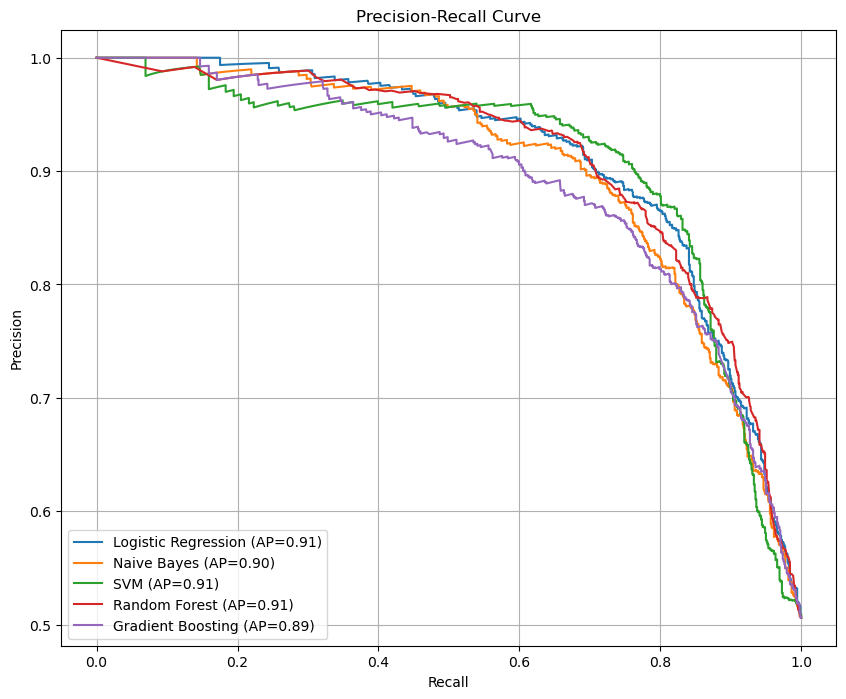

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# 创建空字典存储模型及其预测结果
models = {
    "Logistic Regression": best_logistic,
    "Naive Bayes": best_NB,
    "SVM": best_svm,
    "Random Forest": best_rf,
    "Gradient Boosting": best_GBC
}

# 绘制 Precision-Recall 曲线
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # 如果模型支持 `predict_proba`
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1]  # 获取正类的概率
    elif hasattr(model, "decision_function"):  # 对于 SVM 使用 `decision_function`
        y_scores = model.decision_function(X_val)
    else:
        raise ValueError(f"Model {name} does not support probability or decision function.")
    
    # 计算 Precision-Recall
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    avg_precision = average_precision_score(y_val, y_scores)
    
    # 绘制曲线
    plt.plot(recall, precision, label=f"{name} (AP={avg_precision:.2f})")

# 设置图形细节
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()

plt.savefig("figure/precision_recall_curve.png", dpi=300)  # 设置保存路径和分辨率
plt.show()


In [32]:
# 使用Grandident boosting - XGBoost

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],         # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],      # 学习率
    'max_depth': [3, 5, 7]                  # 每棵树的最大深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_XGB = grid_search.best_estimator_
y_pred = best_XGB.predict(X_val)

# 7. 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
F1 Score: 0.7978848413631022
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       858
           1       0.83      0.77      0.80       879

    accuracy                           0.80      1737
   macro avg       0.80      0.80      0.80      1737
weighted avg       0.80      0.80      0.80      1737



# Unigram

# 将文本数据转换为 TF-IDF 特征，仅使用 unigram
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # ngram_range=(1, 1) 表示只使用 unigram
X = tfidf_vectorizer.fit_transform(train_df['text'])  # 保持稀疏矩阵格式以节省内存
y = train_df['label']

# 将数据分为训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 使用 CountVectorizer 提取 unigram 特征
count_vectorizer = CountVectorizer(ngram_range=(1, 1))  # 仅使用 unigram
X = count_vectorizer.fit_transform(train_df['text'])  # 转换为词频矩阵
y = train_df['label']

# 分割为训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 查看词汇表
print(count_vectorizer.get_feature_names_out())


['aa' 'aaaa' 'aaaaaaallll' ... 'ûónegligence' 'ûótech' 'ûówe']


In [34]:
# 使用logistic regression

# 设置参数网格
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # C 为逻辑回归的正则化参数

# 使用 GridSearchCV 进行交叉验证和参数调优
logreg_model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_logistic = grid_search.best_estimator_
y_pred = best_logistic.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'C': 1}
F1 Score: 0.826036866359447
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       858
           1       0.84      0.82      0.83       879

    accuracy                           0.83      1737
   macro avg       0.83      0.83      0.83      1737
weighted avg       0.83      0.83      0.83      1737



In [35]:
# 使用SVM
# 设置参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

# 使用 GridSearchCV 进行参数调优
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
F1 Score: 0.8421672555948174
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       858
           1       0.87      0.81      0.84       879

    accuracy                           0.85      1737
   macro avg       0.85      0.85      0.85      1737
weighted avg       0.85      0.85      0.85      1737



In [36]:
# 使用naivebayes

# 设置参数网格
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}  # alpha 是 MultinomialNB 的平滑参数

# 使用 GridSearchCV 进行交叉验证和参数调优
nb_model = MultinomialNB()
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_NB = grid_search.best_estimator_
y_pred = best_NB.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'alpha': 0.1}
F1 Score: 0.808284023668639
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       858
           1       0.84      0.78      0.81       879

    accuracy                           0.81      1737
   macro avg       0.82      0.81      0.81      1737
weighted avg       0.82      0.81      0.81      1737



In [37]:
# 使用random forest

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],       # 树的数量
    'max_depth': [None, 10, 20, 30]       # 最大深度，None 表示不限制深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'max_depth': None, 'n_estimators': 200}
F1 Score: 0.8166172106824926
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.83       858
           1       0.85      0.78      0.82       879

    accuracy                           0.82      1737
   macro avg       0.82      0.82      0.82      1737
weighted avg       0.82      0.82      0.82      1737



In [38]:
# 使用gradient boosting

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],         # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],      # 学习率
    'max_depth': [3, 5, 7]                  # 每棵树的最大深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_GBC = grid_search.best_estimator_
y_pred = best_GBC.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
F1 Score: 0.805408583186361
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       858
           1       0.83      0.78      0.81       879

    accuracy                           0.81      1737
   macro avg       0.81      0.81      0.81      1737
weighted avg       0.81      0.81      0.81      1737



# Unigram + Bigram (n=1 and n=2)

# 将文本数据转换为 TF-IDF 特征，使用 unigram 和 bigram
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # ngram_range=(1, 2) 表示使用 unigram 和 bigram
X = tfidf_vectorizer.fit_transform(train_df['text'])  # 保持稀疏矩阵格式以节省内存
y = train_df['label']

# 将数据分为训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 使用 CountVectorizer 提取 unigram 和 bigram 特征
count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # 同时提取 unigram 和 bigram
X = count_vectorizer.fit_transform(train_df['text'])  # 转换为词频矩阵
y = train_df['label']

# 将数据分为训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
# 使用logistic regression

# 设置参数网格
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # C 为逻辑回归的正则化参数

# 使用 GridSearchCV 进行交叉验证和参数调优
logreg_model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_logistic = grid_search.best_estimator_
y_pred = best_logistic.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'C': 1}
F1 Score: 0.8382526564344747
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       858
           1       0.87      0.81      0.84       879

    accuracy                           0.84      1737
   macro avg       0.84      0.84      0.84      1737
weighted avg       0.84      0.84      0.84      1737



Kaggle submission: 0.79466

In [41]:
# 使用SVM
# 设置参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

# 使用 GridSearchCV 进行参数调优
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
F1 Score: 0.8336293664890467
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       858
           1       0.87      0.80      0.83       879

    accuracy                           0.84      1737
   macro avg       0.84      0.84      0.84      1737
weighted avg       0.84      0.84      0.84      1737



In [42]:
# 使用naivebayes

# 设置参数网格
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}  # alpha 是 MultinomialNB 的平滑参数

# 使用 GridSearchCV 进行交叉验证和参数调优
nb_model = MultinomialNB()
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_NB = grid_search.best_estimator_
y_pred = best_NB.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'alpha': 1.0}
F1 Score: 0.8303886925795053
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       858
           1       0.86      0.80      0.83       879

    accuracy                           0.83      1737
   macro avg       0.84      0.83      0.83      1737
weighted avg       0.84      0.83      0.83      1737



In [43]:
# 使用random forest

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],       # 树的数量
    'max_depth': [None, 10, 20, 30]       # 最大深度，None 表示不限制深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'max_depth': None, 'n_estimators': 200}
F1 Score: 0.8133911965282083
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       858
           1       0.89      0.75      0.81       879

    accuracy                           0.83      1737
   macro avg       0.84      0.83      0.83      1737
weighted avg       0.84      0.83      0.83      1737



In [44]:
# 使用gradient boosting

# 设置参数网格
param_grid = {
    'n_estimators': [50, 100, 200],         # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],      # 学习率
    'max_depth': [3, 5, 7]                  # 每棵树的最大深度
}

# 使用 GridSearchCV 进行交叉验证和参数调优
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best parameters:", grid_search.best_params_)

# 使用最优参数在测试集上进行预测
best_GBC = grid_search.best_estimator_
y_pred = best_GBC.predict(X_val)

# 评估模型
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("F1 Score:", f1)
print("Classification Report:\n", report)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
F1 Score: 0.8049353701527615
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       858
           1       0.83      0.78      0.80       879

    accuracy                           0.81      1737
   macro avg       0.81      0.81      0.81      1737
weighted avg       0.81      0.81      0.81      1737

